In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from PIL import Image
from numpy import asarray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from keras_preprocessing.image import ImageDataGenerator,array_to_img,load_img,img_to_array

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_dir='data/train/'
test_dir='data/test/'

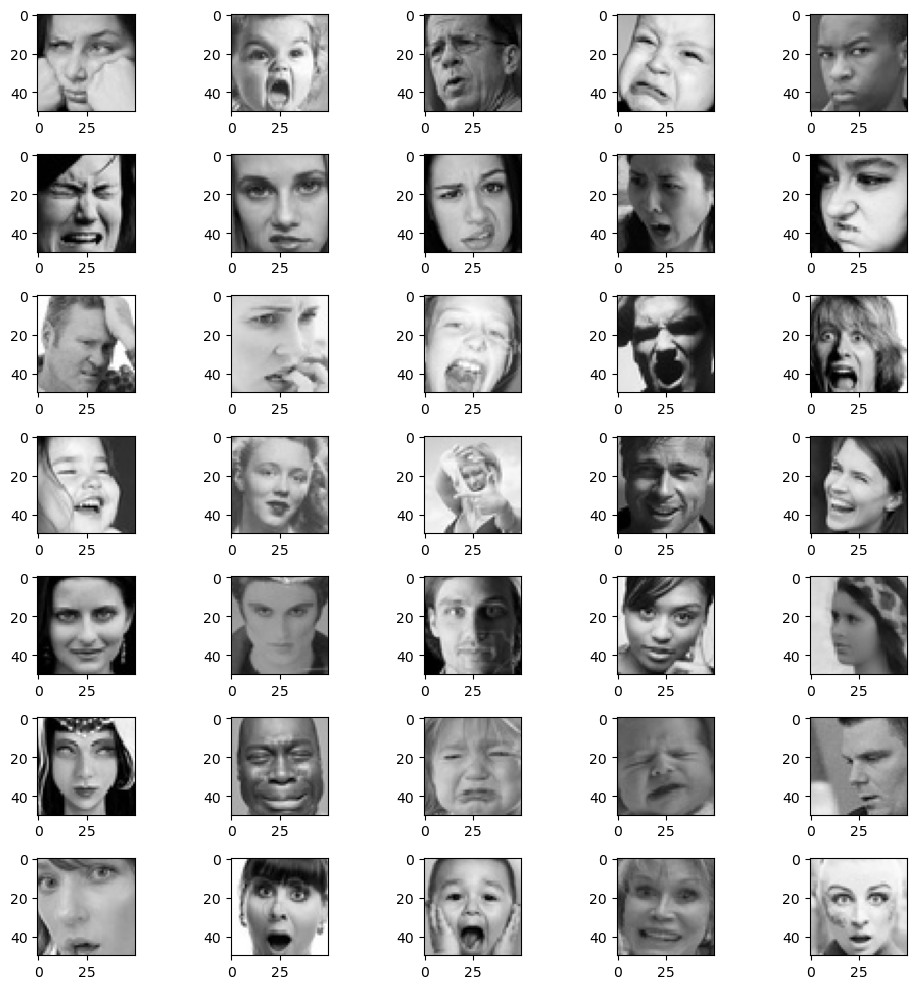

In [4]:
#Plot sample images for all the classes 
size=50
plt.figure(figsize=(10,10))
exp=0
 
for category in os.listdir(train_dir):
    for i in range(1,6):
        exp+=1
        plt.subplot(7,5,exp)
        img=load_img(train_dir+category+'/'+os.listdir(train_dir+category)[i],target_size=(size,size))
        plt.imshow(img,cmap='gray')
plt.tight_layout()
plt.show()

In [5]:
train_class=[]
train_images=[]
for i in os.listdir(train_dir):
    for image_file in os.listdir(train_dir+i):
        train_class.append(i)
        train_images.append(i+'/'+image_file)
train_data=pd.DataFrame(train_images,columns=['Class Image'])
train_data['Classes']=train_class
train_data.head()

,Class Image,Classes
0,angry/train_angry_1.jpg,angry
1,angry/train_angry_10.jpg,angry
2,angry/train_angry_100.jpg,angry
3,angry/train_angry_1000.jpg,angry
4,angry/train_angry_1001.jpg,angry


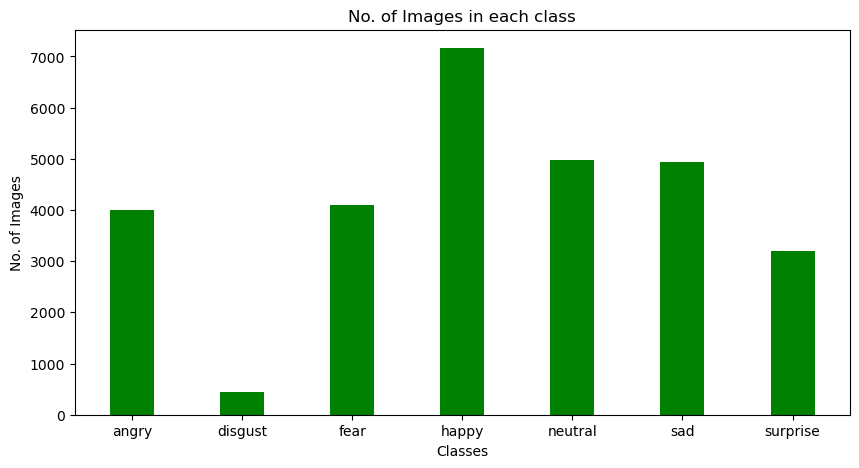

In [6]:
from collections import Counter
train_count=Counter(train_data['Classes'])
key=train_count.keys()
val=train_count.values()
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(key, val, color ='green',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. of Images")
plt.title("No. of Images in each class")
plt.show()

In [31]:
cl_img=train_data.iloc[:,0]
img_arr=[]
for i in cl_img:
    img=Image.open(train_dir+i)
    num_arr=asarray(img).reshape(48,48,1)
    img_arr.append(num_arr)

xtrain=np.array(img_arr)

In [8]:
le=LabelEncoder()
train_data['Classes']= le.fit_transform(train_data['Classes'])
ytrain=train_data.iloc[:,1]
ytrain.unique()

array([0, 1, 2, 3, 4, 5, 6])

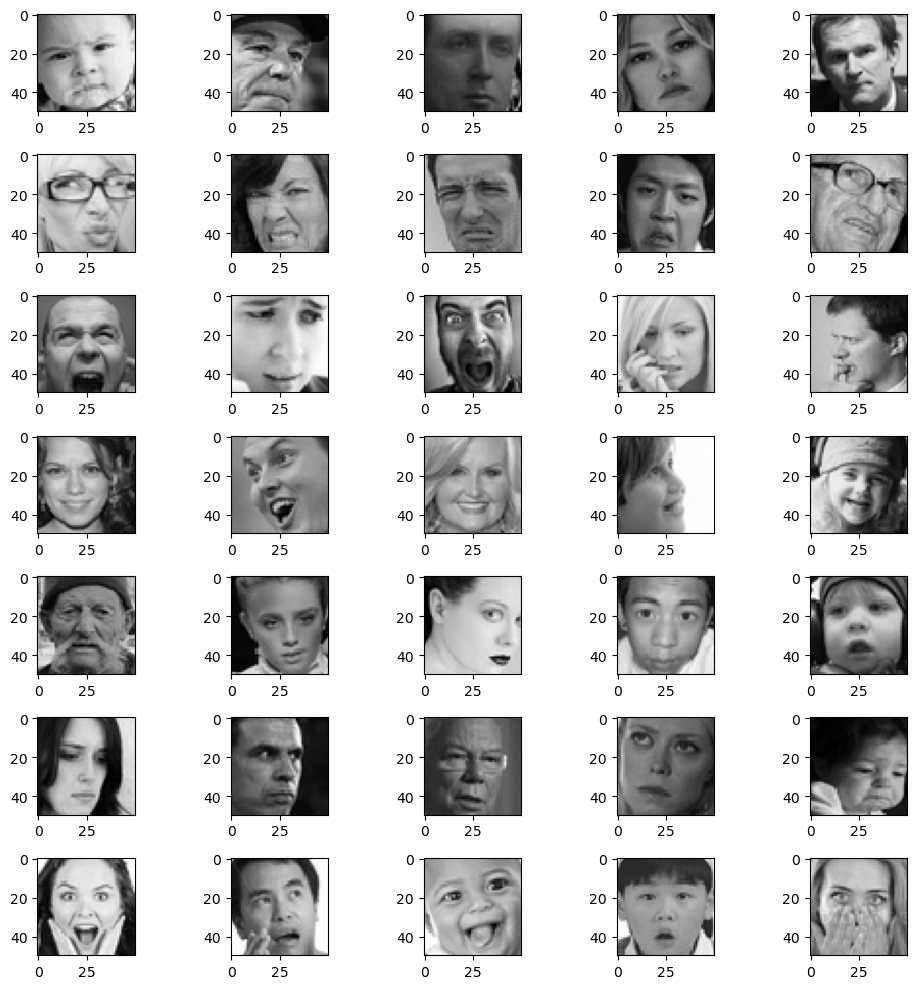

In [9]:
#Perfrom the above steps for test dataset
#Plot sample images for all the classes 
size=50
plt.figure(figsize=(10,10))
exp=0
 
for category in os.listdir(test_dir):
    for i in range(1,6):
        exp+=1
        plt.subplot(7,5,exp)
        img=load_img(test_dir+category+'/'+os.listdir(test_dir+category)[i],target_size=(size,size))
        plt.imshow(img,cmap='gray')
plt.tight_layout()
plt.show()

In [10]:

test_class=[]
test_images=[]
for i in os.listdir(test_dir):
    for image_file in os.listdir(test_dir+i):
        test_class.append(i)
        test_images.append(i+'/'+image_file)
test_data=pd.DataFrame(test_images,columns=['Class Image'])
test_data['Classes']=test_class
test_data.head()

,Class Image,Classes
0,angry/test_angry_1.jpg,angry
1,angry/test_angry_10.jpg,angry
2,angry/test_angry_100.jpg,angry
3,angry/test_angry_101.jpg,angry
4,angry/test_angry_102.jpg,angry


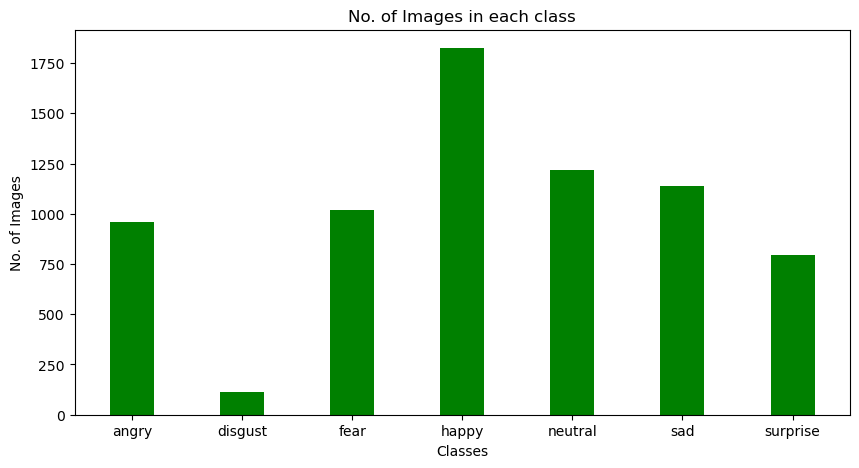

In [11]:
test_count=Counter(test_data['Classes'])
key=test_count.keys()
val=test_count.values()
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(key, val, color ='green',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. of Images")
plt.title("No. of Images in each class")
plt.show()

In [12]:
cl_img2=test_data.iloc[:,0]
img_arr2=[]
for i in cl_img2:
    img=Image.open(test_dir+i)
    num_arr=asarray(img).reshape(48,48,1)
    img_arr2.append(num_arr)

xtest=np.array(img_arr2) 

test_data['Classes']= le.fit_transform(test_data['Classes'])
ytest=test_data.iloc[:,1]
ytest.unique()

array([0, 1, 2, 3, 4, 5, 6])

In [33]:
# Format our training data by Normalizing and changing data type
xtrain = xtrain.astype('float32')
xtest = xtest.astype('float32')
xtrain /= 255
xtest /= 255

# 1.CNN Architecture:

In [14]:
#Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(  rotation_range=30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   rotation_range=30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

In [15]:
datagen.fit(xtrain)
valgen.fit(xtest)
train_generator = datagen.flow(xtrain, ytrain, batch_size=32)
val_generator = valgen.flow(xtest, ytest, batch_size=32)

In [16]:
model=Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
   
model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
      
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='sigmoid'))
model.compile(
    optimizer = Adam(learning_rate= 0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [17]:
es = EarlyStopping(monitor='val_loss',patience=2, verbose = 1)
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=10,   
                    verbose=1,
                    callbacks=es,
                    validation_data=val_generator,
                    validation_steps=100)                             

Epoch 1/10
100/100 [==============================] - 53s 521ms/step - loss: 2.4859 - accuracy: 0.1803 - val_loss: 1.8790 - val_accuracy: 0.1869
Epoch 2/10
100/100 [==============================] - 50s 500ms/step - loss: 2.2114 - accuracy: 0.1916 - val_loss: 2.0832 - val_accuracy: 0.1884
Epoch 3/10
100/100 [==============================] - 49s 487ms/step - loss: 2.0829 - accuracy: 0.2011 - val_loss: 1.8983 - val_accuracy: 0.2550
Epoch 3: early stopping


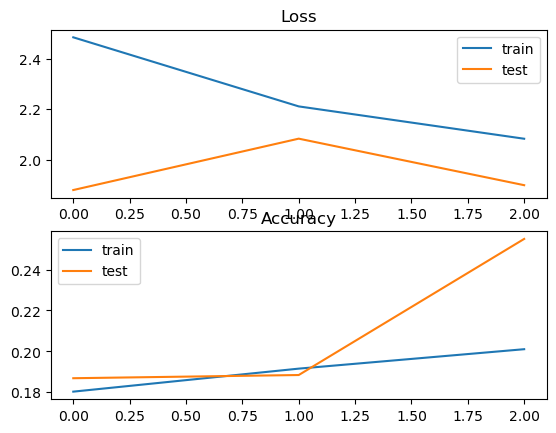

In [18]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [19]:
preds = model.predict(xtest)

221/221 [==============================] - 19s 87ms/step


In [20]:
ytrue = ytest.astype(int).tolist()
ypred = np.argmax(preds, axis=1).tolist()
print(classification_report(ytrue,ypred,digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       960
           1      0.000     0.000     0.000       111
           2      0.000     0.000     0.000      1018
           3      0.262     0.881     0.404      1825
           4      0.141     0.009     0.017      1216
           5      0.229     0.172     0.196      1139
           6      0.000     0.000     0.000       797

    accuracy                          0.257      7066
   macro avg      0.090     0.152     0.088      7066
weighted avg      0.129     0.257     0.139      7066



# 2.Customized CNN Architecture:

In [21]:
model=Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
   
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
      
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='sigmoid'))
model.compile(
    optimizer = RMSprop(learning_rate= 0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [22]:
es = EarlyStopping(monitor='val_loss',patience=2, verbose = 1)
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=10,   
                    verbose=1,
                    callbacks=es,
                    validation_data=val_generator,
                    validation_steps=100)      

Epoch 1/10
100/100 [==============================] - 71s 694ms/step - loss: 2.4996 - accuracy: 0.1850 - val_loss: 1.8559 - val_accuracy: 0.2534
Epoch 2/10
100/100 [==============================] - 73s 735ms/step - loss: 2.2855 - accuracy: 0.1803 - val_loss: 2.3462 - val_accuracy: 0.1434
Epoch 3/10
100/100 [==============================] - 71s 708ms/step - loss: 2.1594 - accuracy: 0.1863 - val_loss: 1.9511 - val_accuracy: 0.2562
Epoch 3: early stopping


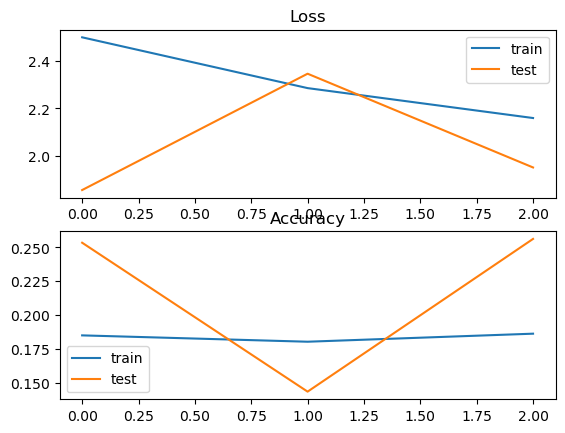

In [23]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [24]:
preds_ccnn = model.predict(xtest)

221/221 [==============================] - 27s 121ms/step


In [25]:
ytrue_ccnn = ytest.astype(int).tolist()
ypred_ccnn = np.argmax(preds_ccnn, axis=1).tolist()
print(classification_report(ytrue_ccnn,ypred_ccnn,digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       960
           1      0.000     0.000     0.000       111
           2      0.000     0.000     0.000      1018
           3      0.260     0.996     0.412      1825
           4      0.000     0.000     0.000      1216
           5      0.000     0.000     0.000      1139
           6      0.329     0.029     0.053       797

    accuracy                          0.261      7066
   macro avg      0.084     0.146     0.066      7066
weighted avg      0.104     0.261     0.113      7066



# 3.Transfer Learning:

In [14]:

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



In [15]:
train_generator=train_datagen.flow_from_directory(train_dir,
                                                 color_mode='rgb',
                                                 target_size=(48,48),
                                                 batch_size=32,
                                                 class_mode='categorical')
test_generator=test_datagen.flow_from_directory(test_dir,
                                                color_mode='rgb',
                                                target_size=(48,48),
                                                batch_size=32,
                                                class_mode='categorical')

Found 28820 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [16]:
from keras.applications.vgg16 import VGG16, preprocess_input
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(48, 48,3))

In [17]:
from keras import layers
NUM_CLASSES = 7

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.layers[0].trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy'])

In [18]:

es = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    patience=2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=15,
    validation_data=test_generator,
    validation_steps=25,
    callbacks=[es],
    verbose=1)

Epoch 1/15
50/50 [==============================] - 17s 335ms/step - loss: 21.5267 - accuracy: 0.1544 - val_loss: 17.5831 - val_accuracy: 0.1562
Epoch 2/15
50/50 [==============================] - 19s 379ms/step - loss: 19.8757 - accuracy: 0.1456 - val_loss: 14.7583 - val_accuracy: 0.1650
Epoch 3/15
50/50 [==============================] - 21s 428ms/step - loss: 18.3838 - accuracy: 0.1781 - val_loss: 14.1482 - val_accuracy: 0.1425
Epoch 4/15
50/50 [==============================] - 22s 434ms/step - loss: 17.6157 - accuracy: 0.1644 - val_loss: 13.2090 - val_accuracy: 0.1412
Epoch 5/15
50/50 [==============================] - 21s 416ms/step - loss: 16.9883 - accuracy: 0.1600 - val_loss: 12.3277 - val_accuracy: 0.1500
Epoch 6/15
50/50 [==============================] - 22s 435ms/step - loss: 16.9028 - accuracy: 0.1781 - val_loss: 11.7930 - val_accuracy: 0.1787
Epoch 7/15
50/50 [==============================] - 22s 446ms/step - loss: 16.2145 - accuracy: 0.1694 - val_loss: 10.8699 - val_ac

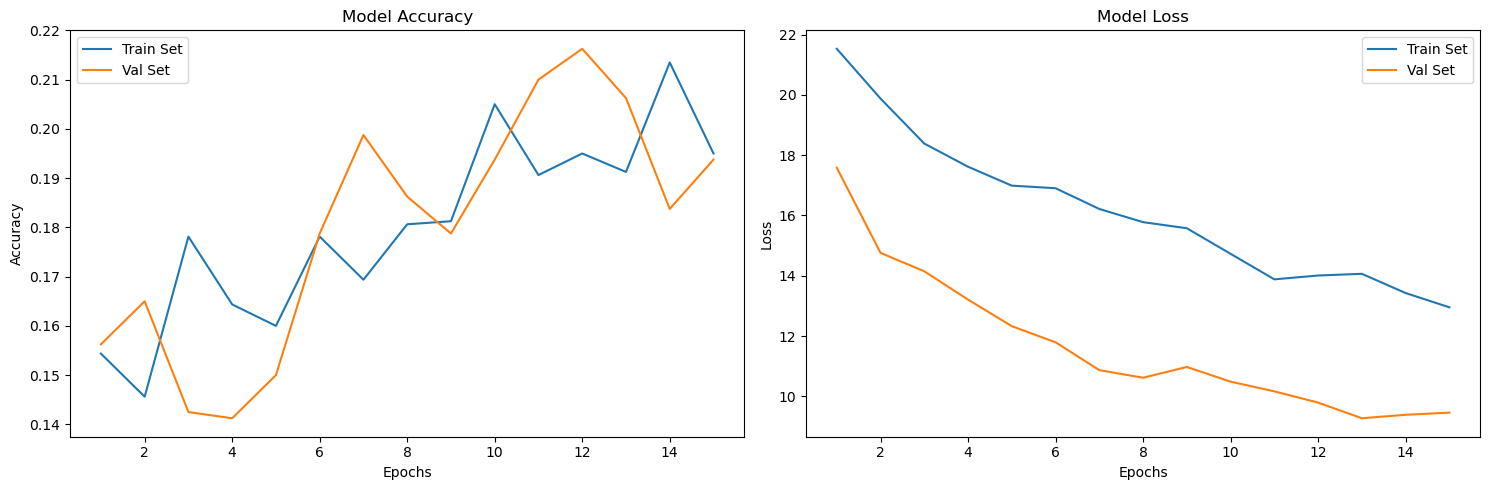

In [19]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [34]:
xtrain = [cv2.cvtColor(cv2.resize(i, (48,48)), cv2.COLOR_GRAY2BGR) for i in xtrain]
xtrain = np.concatenate([arr[np.newaxis] for arr in xtrain]).astype('float32')

In [35]:
xtest = [cv2.cvtColor(cv2.resize(i, (48,48)), cv2.COLOR_GRAY2BGR) for i in xtest]
xtest = np.concatenate([arr[np.newaxis] for arr in xtest]).astype('float32')

In [36]:
pred = model.predict(xtest)

221/221 [==============================] - 270s 1s/step


In [37]:
ytrue = ytest.astype(int).tolist()
pred = np.argmax(pred, axis=1).tolist()
print(classification_report(ytrue,pred,digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       960
           1      0.000     0.000     0.000       111
           2      0.000     0.000     0.000      1018
           3      0.000     0.000     0.000      1825
           4      0.172     1.000     0.294      1216
           5      0.000     0.000     0.000      1139
           6      0.000     0.000     0.000       797

    accuracy                          0.172      7066
   macro avg      0.025     0.143     0.042      7066
weighted avg      0.030     0.172     0.051      7066



# CONCLUSION

In terms of accuracy, the customised cnn gave better results.
And in terms of other parameters, the transfer learning model did better.
In order to improve the model performance:
1) Increase the epoch to 100 (when the epoch was given 25,the accuarcy went above 40%)
2) Change the optimizer to sgd 
3) Change the activation functions for better results.